#LIBERARIES
Handle Imbalanced Data
most machine learning algorithms do not work very well with imbalanced datasets. The following seven techniques can help you, to train a classifier to detect the abnormal class.
1. Use the right evaluation metrics


Applying inappropriate evaluation metrics for model generated using imbalanced data can be dangerous. Imagine our training data is the one illustrated in graph above. If accuracy is used to measure the goodness of a model, a model which classifies all testing samples into “0” will have an excellent accuracy (99.8%), but obviously, this model won’t provide any valuable information for us.

In this case, other alternative evaluation metrics can be applied such as:

Precision/Specificity: how many selected instances are relevant.
Recall/Sensitivity: how many relevant instances are selected.
F1 score: harmonic mean of precision and recall.
MCC: correlation coefficient between the observed and predicted binary classifications.
AUC: relation between true-positive rate and false positive rate.

2. Resample the training set

Apart from using different evaluation criteria, one can also work on getting different dataset. Two approaches to make a balanced dataset out of an imbalanced one are under-sampling and over-sampling.



2.1. Under-sampling


Under-sampling balances the dataset by reducing the size of the abundant class. This method is used when quantity of data is sufficient. By keeping all samples in the rare class and randomly selecting an equal number of samples in the abundant class, a balanced new dataset can be retrieved for further modelling.



2.2. Over-sampling


On the contrary, oversampling is used when the quantity of data is insufficient. It tries to balance dataset by increasing the size of rare samples. Rather than getting rid of abundant samples, new rare samples are generated by using e.g. repetition, bootstrapping or SMOTE (Synthetic Minority Over-Sampling Technique) [1].

Note that there is no absolute advantage of one resampling method over another. Application of these two methods depends on the use case it applies to and the dataset itself. A combination of over- and under-sampling is often successful as well.



3. Use K-fold Cross-Validation in the Right Way


It is noteworthy that cross-validation should be applied properly while using over-sampling method to address imbalance problems.

Keep in mind that over-sampling takes observed rare samples and applies bootstrapping to generate new random data based on a distribution function. If cross-validation is applied after over-sampling, basically what we are doing is overfitting our model to a specific artificial bootstrapping result. That is why cross-validation should always be done before over-sampling the data, just as how feature selection should be implemented. Only by resampling the data repeatedly, randomness can be introduced into the dataset to make sure that there won’t be an overfitting problem.



4. Ensemble Different Resampled Datasets


The easiest way to successfully generalize a model is by using more data. The problem is that out-of-the-box classifiers like logistic regression or random forest tend to generalize by discarding the rare class. One easy best practice is building n models that use all the samples of the rare class and n-differing samples of the abundant class. Given that you want to ensemble 10 models, you would keep e.g. the 1.000 cases of the rare class and randomly sample 10.000 cases of the abundant class. Then you just split the 10.000 cases in 10 chunks and train 10 different models.

Imbalanced data image
This approach is simple and perfectly horizontally scalable if you have a lot of data, since you can just train and run your models on different cluster nodes. Ensemble models also tend to generalize better, which makes this approach easy to handle.



5. Resample with Different Ratios

The previous approach can be fine-tuned by playing with the ratio between the rare and the abundant class. The best ratio  heavily depends on the data and the models that are used. But instead of training all models with the same ratio in the ensemble, it is worth trying to ensemble different ratios.  So if 10 models are trained, it might make sense to have a model that has a ratio of 1:1 (rare:abundant) and another one with 1:3, or even 2:1. Depending on the model used this can influence the weight that one class gets.

Imbalanced data image


6. Cluster the abundant class

An elegant approach was proposed by Sergey on Quora [2]. Instead of relying on random samples to cover the variety of the training samples, he suggests clustering the abundant class in r groups, with r being the number of cases in r. For each group, only the medoid (centre of cluster) is kept. The model is then trained with the rare class and the medoids only.



7. Design Your Models

All the previous methods focus on the data and keep the models as a fixed component. But in fact, there is no need to resample the data if the model is suited for imbalanced data. The famous XGBoost is already a good starting point if the classes are not skewed too much, because it internally takes care that the bags it trains on are not imbalanced. But then again, the data is resampled, it is just happening secretly.

By designing a cost function that is penalizing wrong classification of the rare class more than wrong classifications of the abundant class, it is possible to design many models that naturally generalize in favour of the rare class. For example, tweaking an SVM to penalize wrong classifications of the rare class by the same ratio that this class is underrepresented.

Imbalanced data image

In [570]:
#---------------------------------------------------------------------------------------------->NUMPY
import numpy as np
#---------------------------------------------------------------------------------------------->PANDA
import pandas as pd
#---------------------------------------------------------------------------------------------->PLOTTING
import seaborn as sns
import matplotlib.pyplot as plt
#---------------------------------------------------------------------------------------------->GRID_SEARCH
from sklearn.model_selection import GridSearchCV
#---------------------------------------------------------------------------------------------->SCORE_FOR_REGRESSION
from sklearn.metrics import mean_absolute_error , mean_squared_error ,r2_score
#---------------------------------------------------------------------------------------------->SPLITTING_DATA
from sklearn.model_selection import train_test_split
#---------------------------------------------------------------------------------------------->ENCODING(LabelEncoder,OrdinalEncoder,OrdinalEncoder)
from sklearn.preprocessing import LabelEncoder,OrdinalEncoder,OrdinalEncoder
#---------------------------------------------------------------------------------------------->REGRESSION_MODELS(LinearRegression)
from sklearn.linear_model import LinearRegression,Ridge,Lasso
import missingno as msng
#---------------------------------------------------------------------------------------------->statsmodels(PERFORM_LINEAR_REGRESSION)
import statsmodels.api as sm
#---------------------------------------------------------------------------------------------->EXCEPTION_WARNING
import warnings
warnings.filterwarnings("ignore")
#---------------------------------------------------------------------------------------------->ENSAMBLE_METHOD_WITH(LinearRegression)
from sklearn.ensemble import BaggingRegressor,AdaBoostRegressor,GradientBoostingRegressor,StackingRegressor

#LOAD_DATA

In [571]:
df = pd.read_csv('/content/insurance-data.csv')
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


<Axes: >

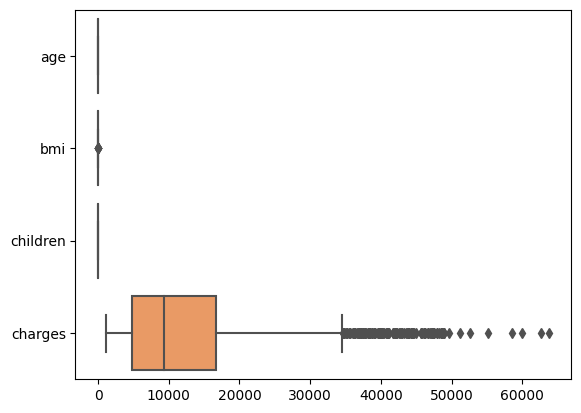

In [572]:
sns.boxplot(data=df,palette='rainbow',orient='h')

#ENCODING

In [573]:
df['smoker'].unique()

array(['yes', 'no'], dtype=object)

In [574]:
df['sex'].unique()

array(['female', 'male'], dtype=object)

In [575]:
df['region'].unique()

array(['southwest', 'southeast', 'northwest', 'northeast'], dtype=object)

In [576]:
ENCODING_MAP = {'yes': 1,'no':0}
df['smoker'] = [ENCODING_MAP[i] for i in df['smoker']]

In [577]:
ENCODING_MAP = {'female': 1,'male':0}
df['sex'] = [ENCODING_MAP[i] for i in df['sex']]

In [578]:
df_dummies = pd.get_dummies(df['region'],drop_first=True, prefix='region')
new_df = pd.concat([df, df_dummies], axis=1)
new_df.drop(['region'],axis=1,inplace=True)

In [579]:
new_df['smoker'].unique()

array([1, 0])

In [580]:
new_df

,age,sex,bmi,children,smoker,charges,region_northwest,region_southeast,region_southwest
0,19,1,27.900,0,1,16884.92400,0,0,1
1,18,0,33.770,1,0,1725.55230,0,1,0
2,28,0,33.000,3,0,4449.46200,0,1,0
3,33,0,22.705,0,0,21984.47061,1,0,0
4,32,0,28.880,0,0,3866.85520,1,0,0
...,...,...,...,...,...,...,...,...,...
1333,50,0,30.970,3,0,10600.54830,1,0,0
1334,18,1,31.920,0,0,2205.98080,0,0,0
1335,18,1,36.850,0,0,1629.83350,0,1,0
1336,21,1,25.800,0,0,2007.94500,0,0,1


#SPLITTING_DATA

In [581]:
x=new_df.loc[:,new_df.columns != 'charges']
y=new_df['charges']

In [582]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=.2,random_state=42)
x_train,x_valid,y_train,y_valid =train_test_split(x_train,y_train,test_size=.1, random_state=42)

#GRIDE_SEARCH_LINEAR_REGRESSION

In [583]:
G_L_REG = GridSearchCV(
            estimator=LinearRegression(),
           param_grid= {'fit_intercept': [True, False], 'positive': [True, False]})
grid_result= G_L_REG.fit(x_train,y_train)
print(grid_result.best_params_)

{'fit_intercept': True, 'positive': True}


In [584]:
y_pred_test_L=grid_result.predict(x_test)
score_test_L=r2_score(y_test,y_pred_test_L)*100
print("score_test_L_V for our test dataset with tuning is : {:.2f}%".format(score_test_L))

score_test_L_V for our test dataset with tuning is : 78.11%


#USING_STATSMODELS TO _PERFORM_LINEAR_REGRESSION

In [585]:
x_train_sm = sm.add_constant(x_train)
lr = sm.OLS(y_train, x_train_sm).fit()
lr.params

const              -12012.331208
age                   253.077625
sex                   198.144887
bmi                   340.717731
children              388.948734
smoker              23520.468569
region_northwest     -526.976635
region_southeast     -558.230211
region_southwest     -785.546767
dtype: float64

In [586]:
print(lr.summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.740
Model:                            OLS   Adj. R-squared:                  0.737
Method:                 Least Squares   F-statistic:                     338.7
Date:                Tue, 19 Dec 2023   Prob (F-statistic):          1.35e-272
Time:                        22:01:41   Log-Likelihood:                -9756.6
No. Observations:                 963   AIC:                         1.953e+04
Df Residuals:                     954   BIC:                         1.957e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -1.201e+04   1186.345  

In [587]:
x_test_sm = sm.add_constant(x_test)
y_pred_sm = lr.predict(x_test_sm)

In [588]:
score_test_L_SM=r2_score(y_test,y_pred_sm)*100
print("score_test_L_SM for our test dataset with tuning is : {:.2f}%".format(score_test_L_SM))

score_test_L_SM for our test dataset with tuning is : 78.27%


#Bagging_REG(MODEL_LINEAR_REGRESSION)

In [589]:
BAGG_L_REG= BaggingRegressor(base_estimator=LinearRegression(),
                                max_samples=500,
                                bootstrap=False,
                                random_state=0)
BAGG_L_REG.fit(x_train,y_train)
y_pred_BAGG_L_REG = BAGG_L_REG.predict(x_test)
score_test_BAGG_L_REG=r2_score(y_test,y_pred_BAGG_L_REG)*100
print("score_test_BAGG_L_REG for our test dataset with tuning is : {:.2f}%".format(score_test_BAGG_L_REG))

score_test_BAGG_L_REG for our test dataset with tuning is : 78.35%


#ADA_BOOST_REG(MODEL_LINEAR_REGRESSION)

In [590]:
ADA_L_REG= AdaBoostRegressor(base_estimator=LinearRegression(),
                                random_state=0, n_estimators=500)
ADA_L_REG.fit(x_train,y_train)
y_pred_ADA_L_REG = ADA_L_REG.predict(x_test)
score_test_ADA_L_REG=r2_score(y_test,y_pred_ADA_L_REG)*100
print("score_test_ADA_L_REG for our test dataset with tuning is : {:.2f}%".format(score_test_ADA_L_REG))

score_test_ADA_L_REG for our test dataset with tuning is : 75.94%


#GRADIENT_BOOST_REG(MODEL_LINEAR_REGRESSION)

In [591]:
GRD_L_REG= GradientBoostingRegressor(init=LinearRegression(),
                                random_state=0, n_estimators=500)
GRD_L_REG.fit(x_train,y_train)
y_pred_GRD_L_REG = GRD_L_REG.predict(x_test)
score_test_GRD_L_REG=r2_score(y_test,y_pred_GRD_L_REG)*100
print("score_test_GRD_L_REG for our test dataset with tuning is : {:.2f}%".format(score_test_GRD_L_REG))

score_test_GRD_L_REG for our test dataset with tuning is : 85.81%


#STACKING_REG(MODEL_LINEAR_REGRESSION)

In [592]:
estimators = [
   ('L_REG', LinearRegression()),
  #  'svr', LinearSVR(dual="auto", random_state=42)
  ]

In [593]:
STACK_L_REG= StackingRegressor(estimators=estimators,
                               final_estimator=LinearRegression())
STACK_L_REG.fit(x_train,y_train)
y_pred_STACK_L_REG = STACK_L_REG.predict(x_test)
score_test_STACK_L_REG=r2_score(y_test,y_pred_STACK_L_REG)*100
print("score_test_STACK_L_REG for our test dataset with tuning is : {:.2f}%".format(score_test_STACK_L_REG))

score_test_STACK_L_REG for our test dataset with tuning is : 78.25%


#FINAL_RESULTS_SCORES_USING_ENAMBLED_METHODS_PLOTTING

Text(0.5, 1.0, 'SCORE_ENSAMBLED_METHODS_APPLIED_ON_REGRESSION')

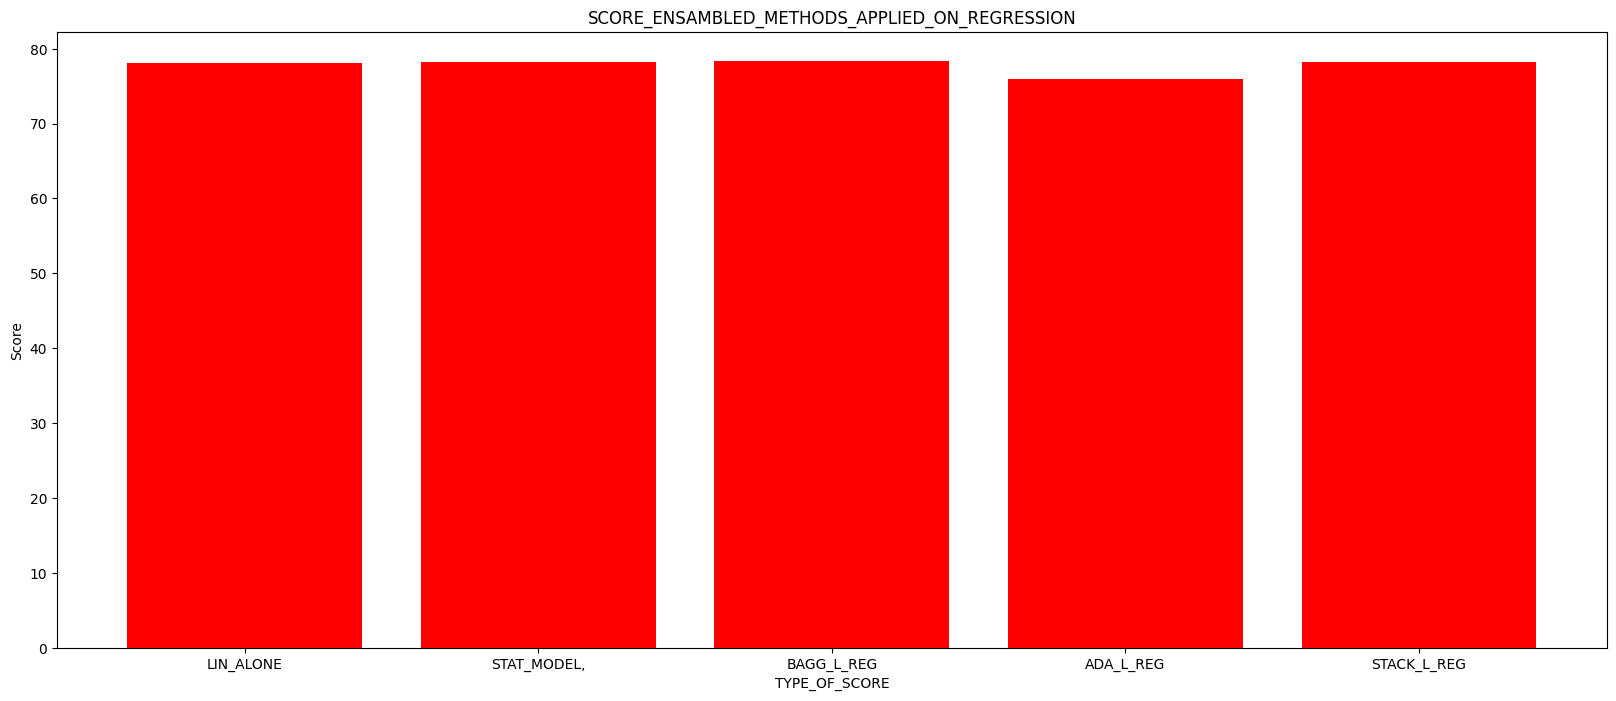

In [594]:
X= ["LIN_ALONE","STAT_MODEL,","BAGG_L_REG","ADA_L_REG","STACK_L_REG"]
Y=[score_test_L,score_test_L_SM ,score_test_BAGG_L_REG,score_test_ADA_L_REG,score_test_STACK_L_REG]
plt.figure(figsize=(20,8))
plt.bar(X , Y,color='RED')
plt.xlabel("TYPE_OF_SCORE")
plt.ylabel("Score")
plt.title("SCORE_ENSAMBLED_METHODS_APPLIED_ON_REGRESSION")

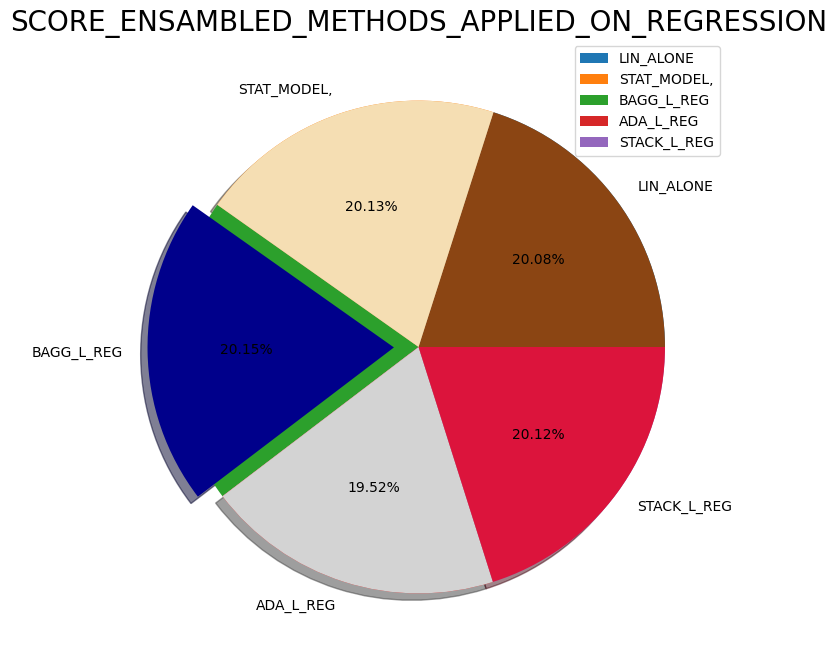

In [610]:
X= ["LIN_ALONE","STAT_MODEL,","BAGG_L_REG","ADA_L_REG","STACK_L_REG"]
DATA=[78.11239758606128,78.27205691672347,78.35195371501264,75.9357797810233,78.25414533881785]
colors = ['saddlebrown', 'wheat', 'darkblue', 'lightgrey','crimson']
EXPLOD = [0.0, 0.0, 0.1, 0.0,0.0]
plt.figure(figsize=(50, 8))
plt.pie(DATA)
plt.title("SCORE_ENSAMBLED_METHODS_APPLIED_ON_REGRESSION", fontsize=20)
plt.legend(X)
plt.pie(DATA,
        explode=EXPLOD,
        labels=X,
        colors=colors,
        autopct='%.2f%%',
        shadow=True)
plt.show()